In [1]:

#Here come my imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Input, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#Load data
month_df=pd.read_csv('monthly_energy_consumption.csv',index_col=[0],parse_dates=True)
n_test=len(month_df.loc['2017':'2018'])
month_df.head()

,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0


Data Points 19


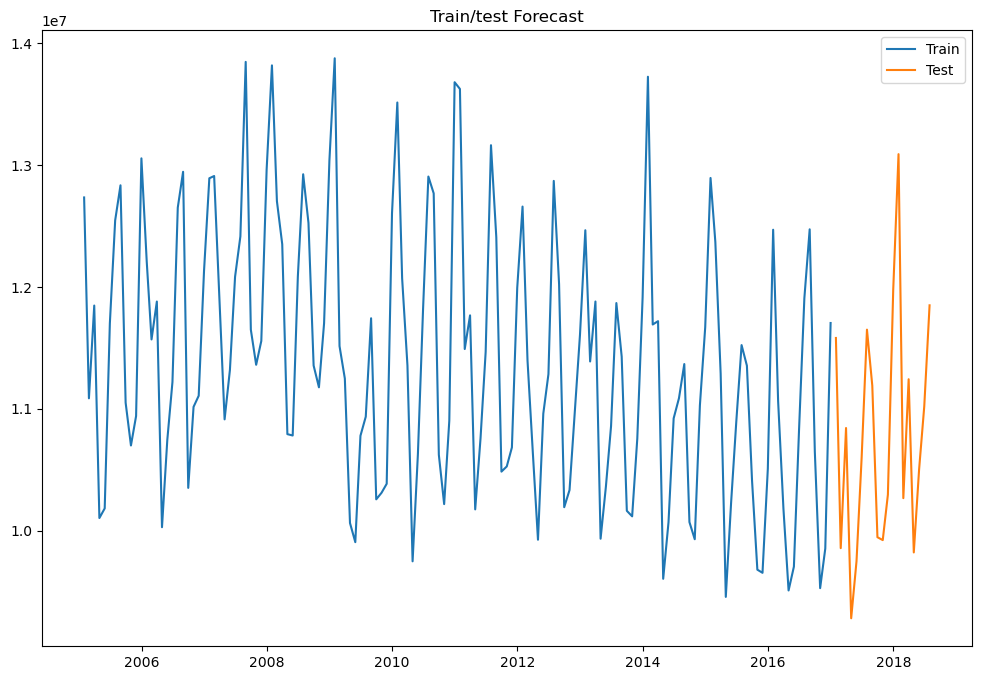

In [3]:
#This time around we have to define the number of the data points belonging to the test
n_test=len(month_df.loc['2017':'2018'])
print('Data Points', n_test)
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
#plt.plot(month_df.index[-n_test:],preds, label='RandomForest')
plt.legend(loc='best')
plt.title("Train/test Forecast");

In [4]:
## Loading the dataframe with previous RMSE where we stored results
results=pd.read_csv('scores.csv',index_col=[0])
results

,rmse_per_million
XGboost_tt,0.478882
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
RandomForest_tt,0.611217
arima,0.737348
RandomForest_bu,0.863608
XGBoost_bu,0.887924
holt_linear,0.929768
SES,0.942778


<a id='start'></a>

## LSTM (long Short-Term Memory) Recurrent Neural Network

* As my fourth discovery trip into Time Series starts, I am going to give it a try with Long Short-Term Memory Network or LSTM network in some different styles.<br/>

 * I use as a refernce this link from [Jason Brownlee (Thank you)](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)



    1. [**LSTM Network for Regression**](#lstm_reg). Let's create from the one column dataset a 2-columns dataset where the latter dataset contains the energy consumption from a previuos period.<br>
    2. [**LSTM for Regression Using the Window Method**](#lstm_window). We are building up from the previous model. Now, we will add more periods in our dataset widening the perios or the window. With a window value of 3, RMSE barely improved but not if we iuncreased it up to 5. Caveats, we are reducing the size of our test when we increase the windows<br>
     3. [**LSTM for Regression with Time Steps**](#lstm_timesteps). This is a different way to represent a problem. The only big change is the reshaping of the data. Let's make every period more than a feature each, a row.<br>
     4. [**LSTM with Memory Between Batches**](#lstm_membatches). The way the network works, it does reset the state of after every batch.If you want to control it yourself, you can do it adding stateful=True with LSTM and avoid shuffling when fitting adding shuffle=False.<br>
     5. [**Stacked LSTMs with Memory Between Batches**](#lstm_stacked). It is about training the model and stacking it at the same time by setting return_sequences to True<br>



In [7]:
test=month_df[-n_test:].values
train=month_df[:-n_test].values

# fix random seed for reproducibility
tf.random.set_seed(55)

#scaling data
scaler=MinMaxScaler(feature_range=(-1,1))
train=scaler.fit_transform(train)
test=scaler.transform(test)
##making sure that I have numpy arrays to work with and creating and X and y with 1 lookback 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
#For a better understanding of what we are doing
a=create_dataset(train,2)
print(train[:3])
print(a[0][:3,0])

[[ 0.48324219]
 [-0.26262064]
 [ 0.08185426]]
[ 0.48324219 -0.26262064  0.08185426]


<a id='LSTM_reg'></a>

<a id='lstm_reg'></a>
## 1. LSTM Network for Regression.

[Back top](#start)

In [14]:
trainX, trainY =create_dataset(train)
testX,testY =create_dataset(test)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) 

In [ ]:
trainX.shape, testX.shape

In [15]:
look_back=1
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
# #reshaping the arrays. This is the most confusing part.===>samples, time steps, features
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) 

# create, compile and fit the LSTM network
model = Sequential()
model.add(Input(shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY))
# make predictions
testPredict = model.predict(testX)
# # invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Test Score: 1042705.15 RMSE


In [ ]:
testX.shape

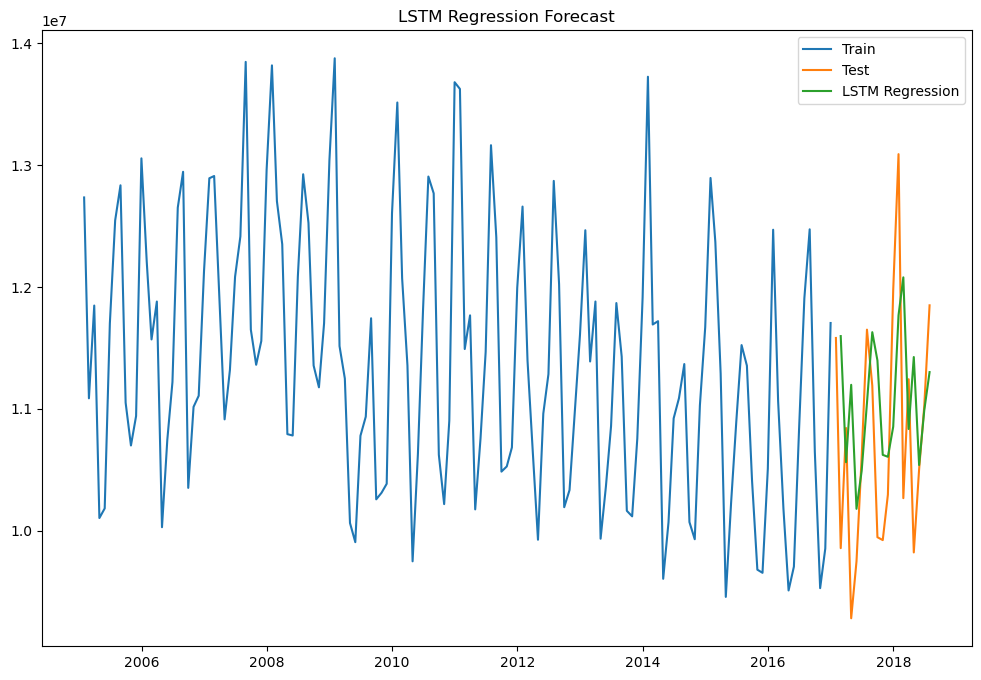

In [16]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test+1:],testPredict[:,0], label='LSTM Regression')
plt.legend(loc='best')
plt.title("LSTM Regression Forecast");

<a id='lstm_window'></a>
## 2. LSTM for Regression Using the Window Method
[back top](#start)

In [17]:
# It is about changing the lookback value up to 3
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping===>samples, time steps, features
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(Input( shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY))
# make predictions
testPredict = model.predict(testX)
# invert predictions

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/1_000_000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test Score: 1.07 RMSE


In [18]:
# It is about changing the lookback value up to 3
look_back=5
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(Input( shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY))
# make predictions
testPredict = model.predict(testX)
# invert predictions

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/1_000_000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test Score: 0.56 RMSE


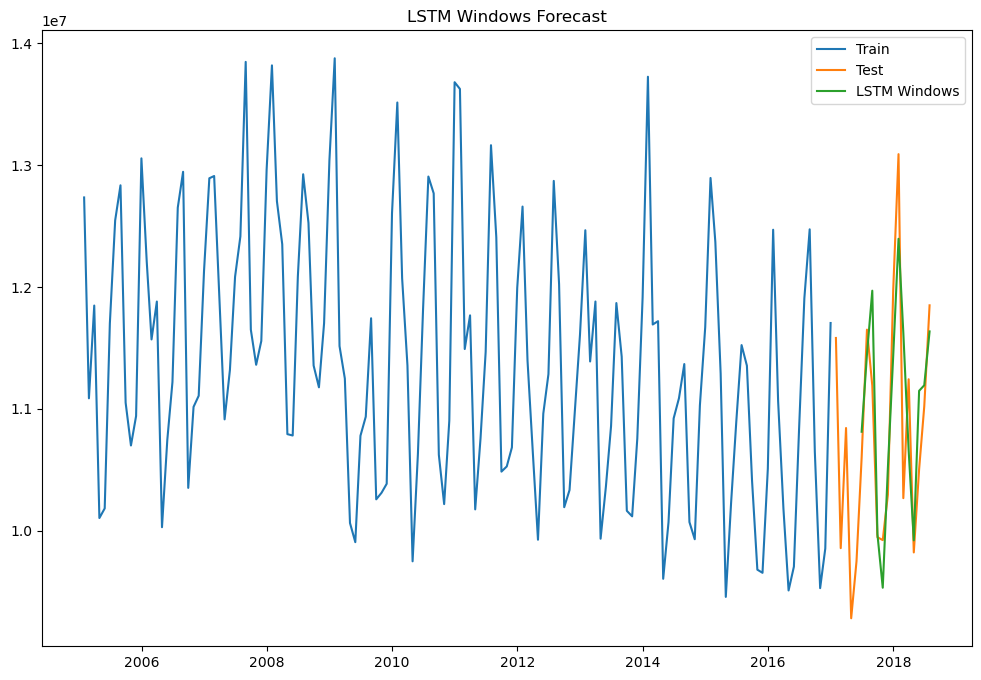

In [19]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-testY.shape[1]:],testPredict[:,0], label='LSTM Windows')
plt.legend(loc='best')
plt.title("LSTM Windows Forecast");

In [20]:
results.loc['LSTM']=testScore/1_000_000
results.sort_values('rmse_per_million')

,rmse_per_million
XGboost_tt,0.478882
holt_winter,0.543067
LSTM,0.557788
prophet,0.571666
SARIMAX,0.590999
RandomForest_tt,0.611217
arima,0.737348
RandomForest_bu,0.863608
XGBoost_bu,0.887924
holt_linear,0.929768


<a id='lstm_timesteps'></a>
## 3. LSTM for Regression with Time Steps.
[back top](#start)

In [21]:
look_back=5
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays===>samples, time steps, features
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

model = Sequential()
model.add(Input(shape=(look_back,1)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY))
# make predictions
testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/1_000_000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Test Score: 0.73 RMSE


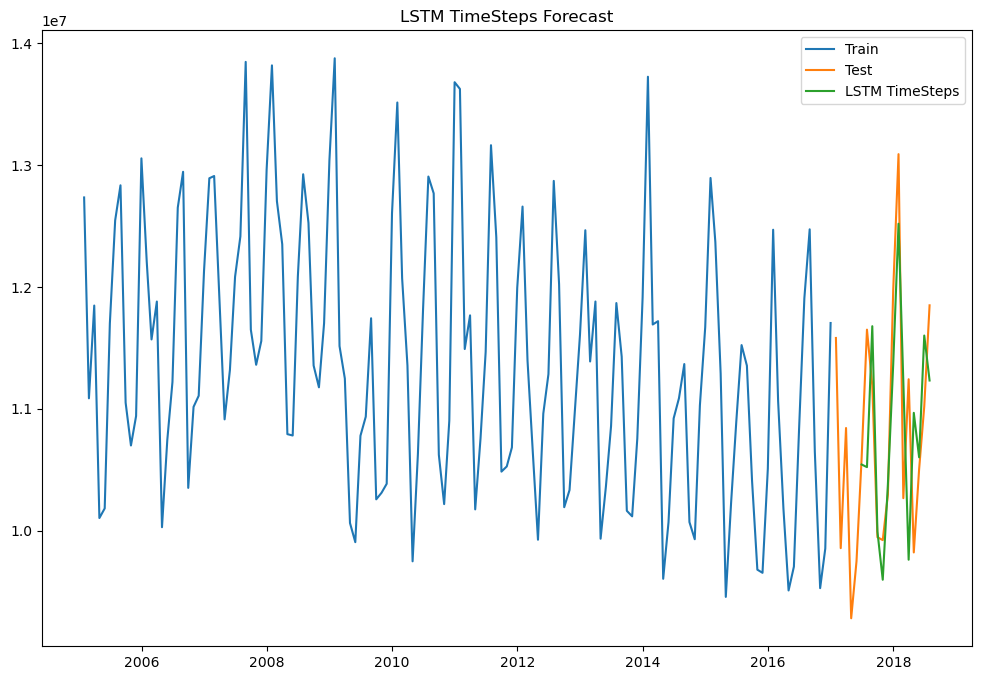

In [22]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-testY.shape[1]:],testPredict[:,0], label='LSTM TimeSteps')
plt.legend(loc='best')
plt.title("LSTM TimeSteps Forecast");

<a id='lstm_membatches'></a>
## 4. LSTM with Memory Between Batches.
[back top](#start)

In [39]:
look_back=5
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrayss===>samples, time steps, features
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True))  #We add stateful as True as we remember the previuos state
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0,validation_data=(testX, testY),shuffle=False)
    #model.reset_states(my_model)
# make predictions
testPredict = model.predict(testX,batch_size=batch_size)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/1_000_000))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Test Score: 0.67 RMSE


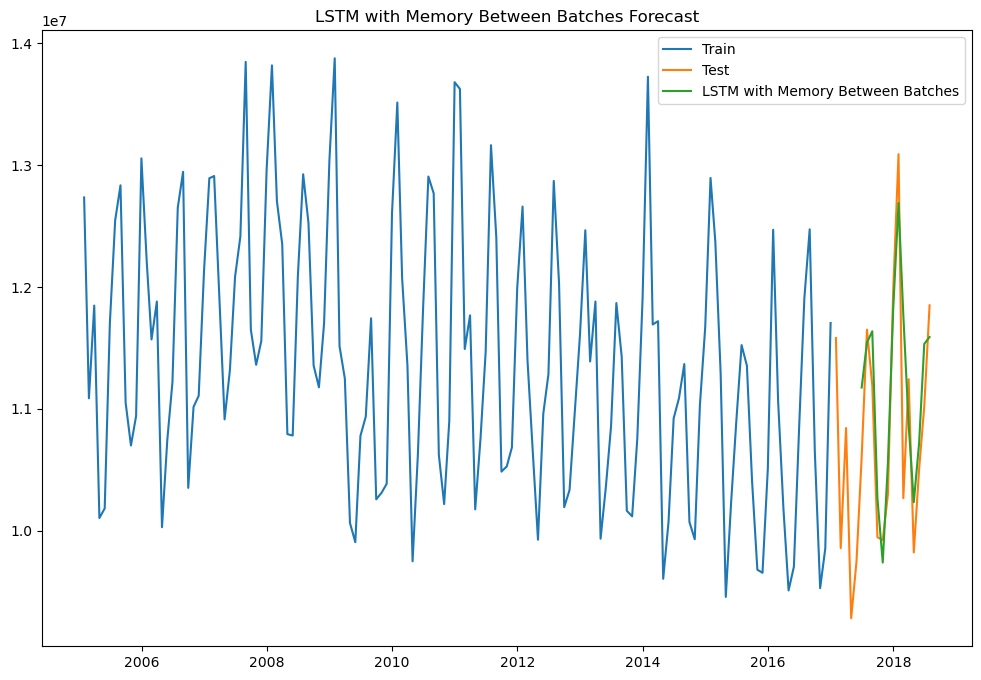

In [38]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-testY.shape[1]:],testPredict[:,0], label='LSTM with Memory Between Batches')
plt.legend(loc='best')
plt.title("LSTM with Memory Between Batches Forecast");

<a id='lstm_stacked'></a>
## 5. Stacked LSTMs with Memory Between Batches.
[back top](#start)

In [42]:
look_back=5
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True,return_sequences=True))
model.add(LSTM(4,stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0,validation_data=(testX, testY),shuffle=False)
    #model.reset_states()
# make predictions
testPredict = model.predict(testX,batch_size=batch_size)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/1_000_000))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
Test Score: 0.60 RMSE


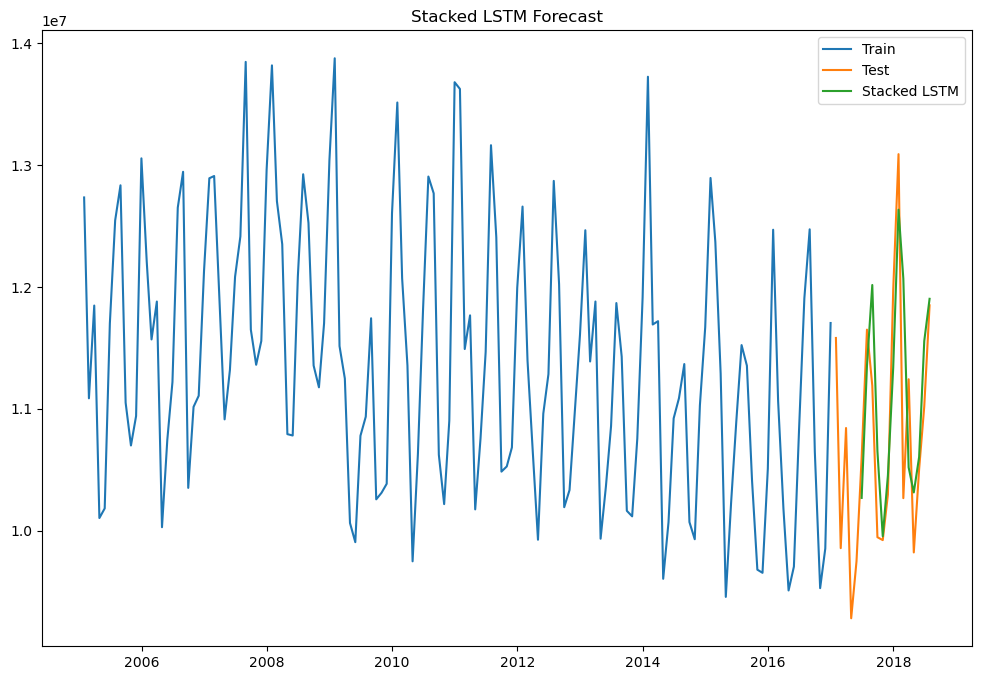

In [41]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-testY.shape[1]:],testPredict[:,0], label='Stacked LSTM')
plt.legend(loc='best')
plt.title("Stacked LSTM Forecast");

In [49]:
results.sort_values('rmse_per_million').to_csv('scores.csv')

# Next Steps
* Differencing. It is a common practice in Tome Series that, using NN, is not that necessary. In any case it could improve my scores.
* Encapsulation. As a way to get to understand what is going on it is not a bad thing to present the code in a "raw" manner. In any case, any further ananlysis would incorporate more functions for readability.